In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.stats as stats
import numpy.random  as rng

In [3]:
dfe = pd.read_csv('iso2.csv')


In [4]:
parameters = ['r1_temp', 'r2_temp', 'r1_pressure', 'r2_pressure']
outputs = ['process_ron', 'process_yield']
subdf = dfe[parameters + outputs]
r = subdf.corr(method='spearman')
final_result = r.loc[parameters, outputs]
final_result.to_excel('tmp/table1.xlsx')

# R1 Temperature Analysis

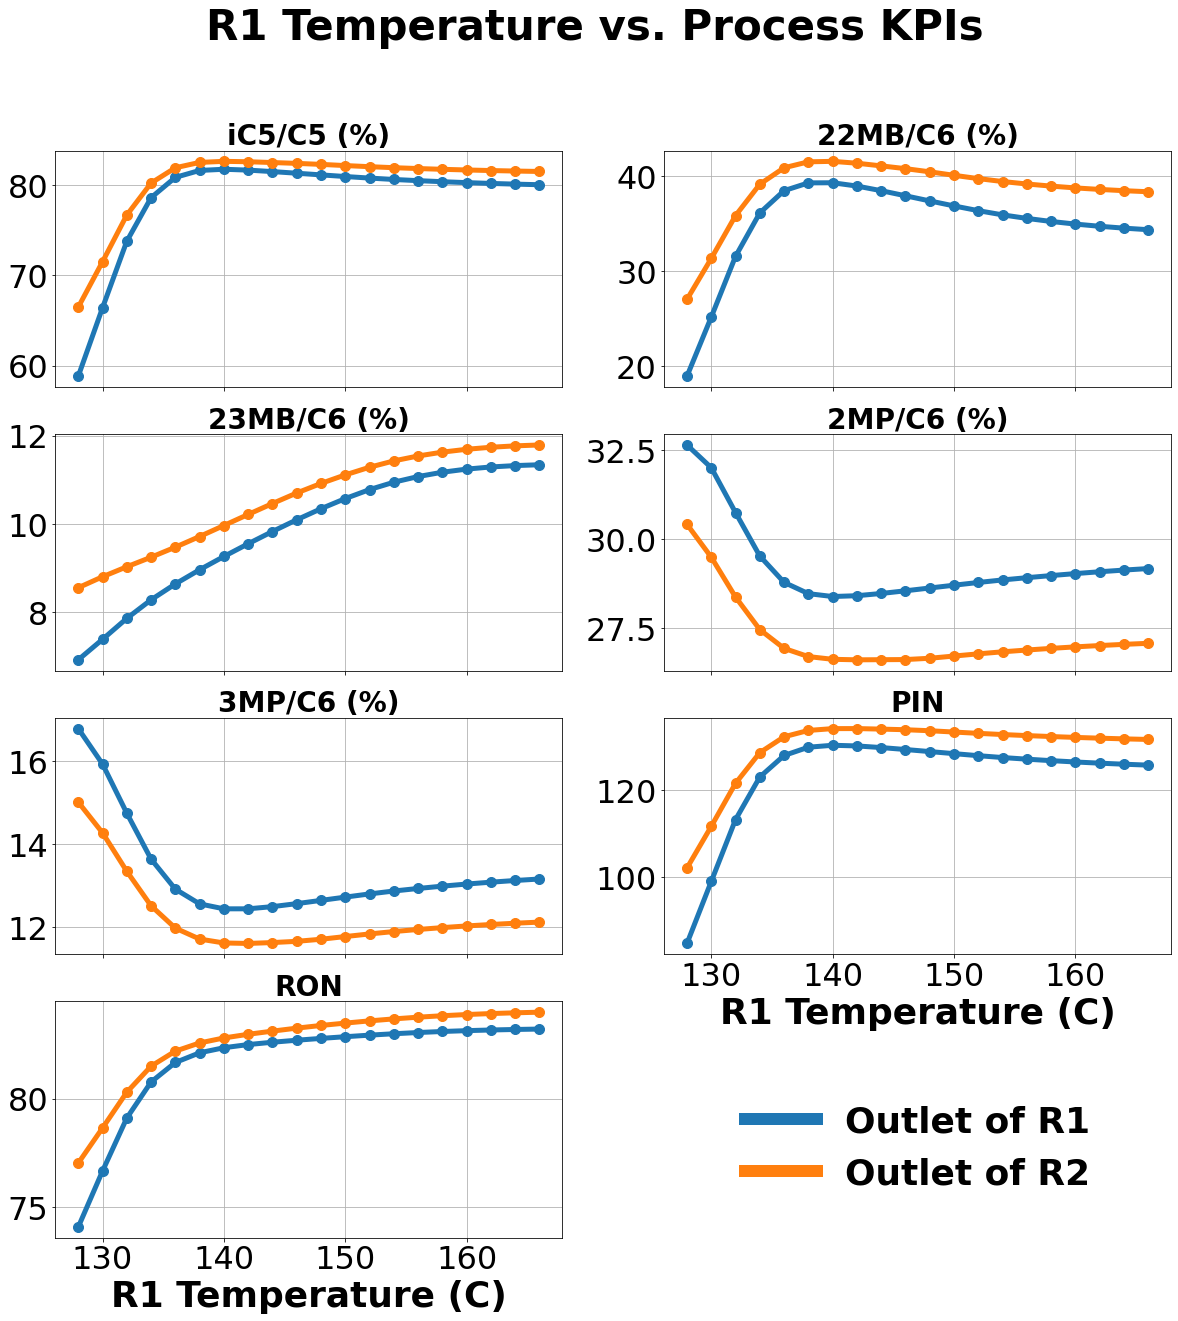

In [5]:

sweep_col = 'r1_temp'
sweep_col_title = 'R1 Temperature (C)'
ix = (dfe['r2_temp'] == 128) & (dfe['r1_pressure'] == 50) & (dfe['r2_pressure'] == 50)
sdf = dfe[ix].copy()
sdf.sort_values([sweep_col], inplace=True)

cols_to_plot = [
    #("c4yield", "C4 Yield (%)"),
    #("c5yield", "C5 Yield (%)"),
   # ("iso_ratio_c4", "iC4/C4 (%)"),
    ("iso_ratio_c5", "iC5/C5 (%)"),
    ("iso_ratio_c6_22mb", "22MB/C6 (%)"),
    ("iso_ratio_c6_23mb", "23MB/C6 (%)"),
    ("iso_ratio_c6_2mp", "2MP/C6 (%)"),
    ("iso_ratio_c6_3mp", "3MP/C6 (%)"),
    #("iso_ratio_c7", "iC7/C7 (%)"),
    ("pin", "PIN"),
    ("ron", "RON")
]
n = len(cols_to_plot)

f, axes = plt.subplots(int(np.ceil(n / 2)), 2, figsize=(20, 20))
axes = axes.flatten()
for i, r in enumerate(zip(cols_to_plot, axes)):
    col_to_plot, ax = r
    col, title = col_to_plot
    ax.plot(sdf[sweep_col], sdf['r1_%s' % col], linewidth=5, marker='o', markersize=10, label='Outlet of R1')
    ax.plot(sdf[sweep_col], sdf['r2_%s' % col], linewidth=5, marker='o', markersize=10, label='Outlet of R2')
    ax.tick_params(axis='x', labelsize=32)
    ax.tick_params(axis='y', labelsize=32)
    
    if i >= 5:
        ax.set_xlabel(sweep_col_title, fontsize=36, fontweight='bold')
    else:
        ax.set_xticklabels([])
    
    if i == 5:
        # Put a legend below current axis
        legend = ax.legend(loc='upper center', 
                  frameon=False,
                  bbox_to_anchor=(0.5, -.5),
                  fancybox=False, 
                  shadow=False,
                  ncol=1,
                  prop={'weight':'bold', 'size':36})
        for line in legend.get_lines():
            line.set_linewidth(12.0)
    ax.set_title(title, fontsize=28, fontweight='bold')
    ax.grid(True)
axes[-1].axis('off')
plt.suptitle('R1 Temperature vs. Process KPIs', fontsize=42, fontweight='bold')
plt.savefig("tmp/fig3.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, pil_kwargs={"compression": "tiff_lzw"})

# Production Proportions as Function of R1 Temperature

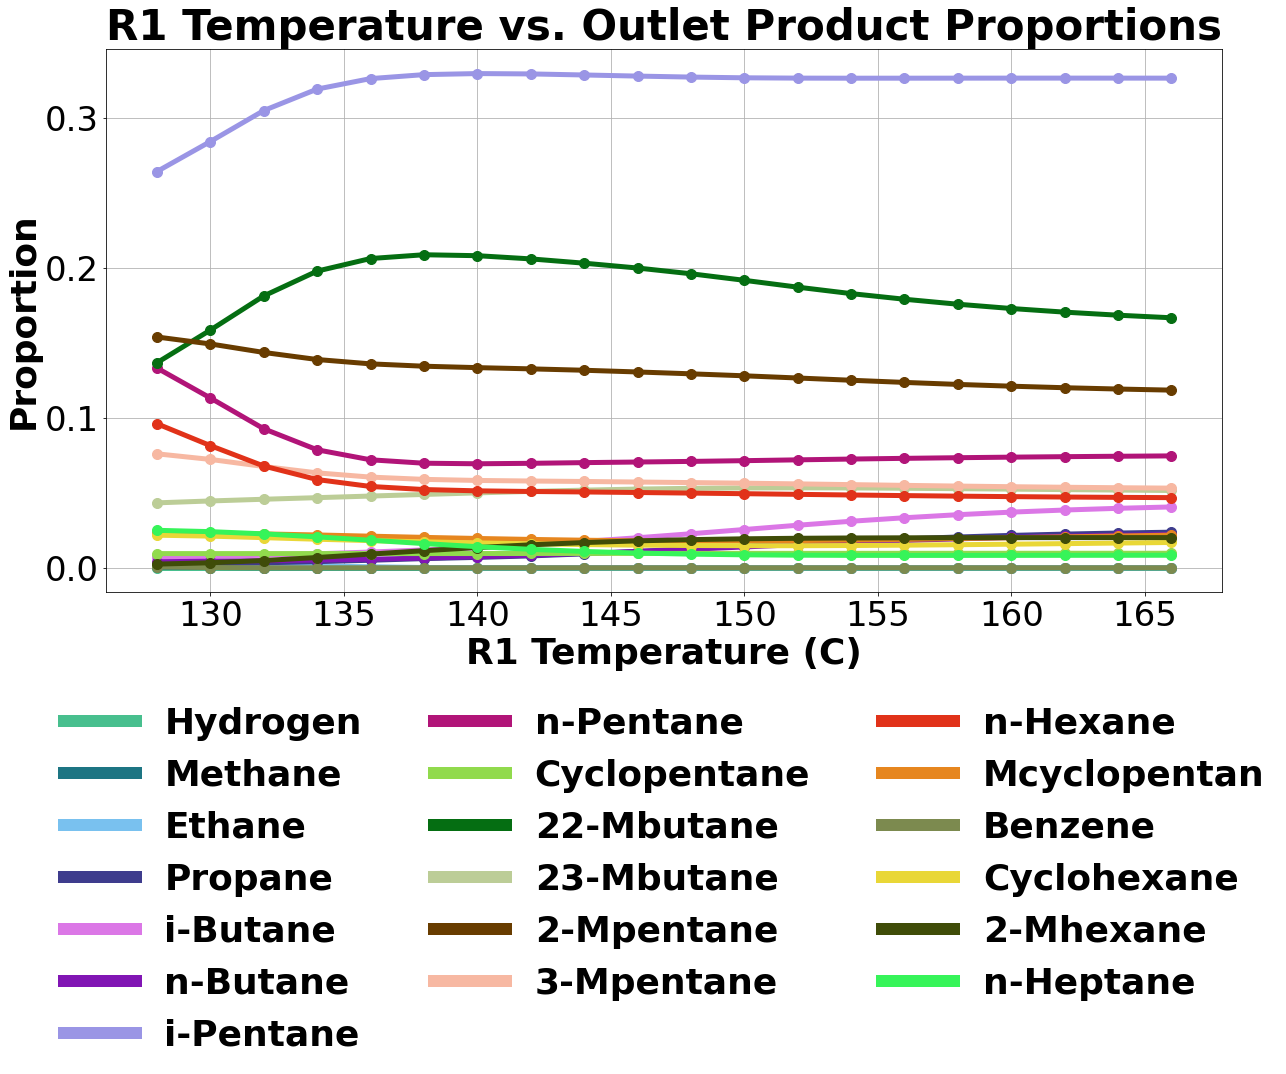

In [6]:
product_cols = [
"Hydrogen",
"Methane",
"Ethane",
"Propane",
"i-Butane",
"n-Butane",
"i-Pentane", 
"n-Pentane",
"Cyclopentane",
"22-Mbutane",
"23-Mbutane",
"2-Mpentane",
"3-Mpentane",
"n-Hexane",
"Mcyclopentan",
"Benzene",
"Cyclohexane",
"2-Mhexane",
"n-Heptane"]
product_colors = ["#48bf8e", "#1d7583", "#79c1ef", "#3e3c8d", "#db77e6", "#8115b4", "#9a95e5", "#b11478", "#91da4d", "#056e12", "#bccd97", "#683c00", "#f7b8a2", "#e13219", "#e6861f", "#7c8a4f", "#e9d737", "#3f4c08", "#36f459"]

f, ax = plt.subplots(1, 1, figsize=(20, 10))
for col, color in zip(product_cols, product_colors):
    ax.plot(sdf['r1_temp'], sdf['process_%s' % col], linewidth=5, marker='o', markersize=10, label=col, color=color)

ax.tick_params(axis='x', labelsize=34)
ax.tick_params(axis='y', labelsize=34)
ax.set_xlabel('R1 Temperature (C)', fontsize=36, fontweight='bold')
ax.set_ylabel('Proportion', fontsize=36, fontweight='bold')
ax.grid('both')
legend = ax.legend(loc='upper center', 
                  frameon=False,
                  bbox_to_anchor=(0.5, -.15),
                  fancybox=False, 
                  shadow=False,
                  ncol=3,
                  prop={'weight':'bold', 'size':36})
for line in legend.get_lines():
    line.set_linewidth(12.0)
ax.set_title('R1 Temperature vs. Outlet Product Proportions', fontsize=42, fontweight='bold')
plt.savefig("tmp/fig4.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, pil_kwargs={"compression": "tiff_lzw"})

# Spearman Correlations of Process Products

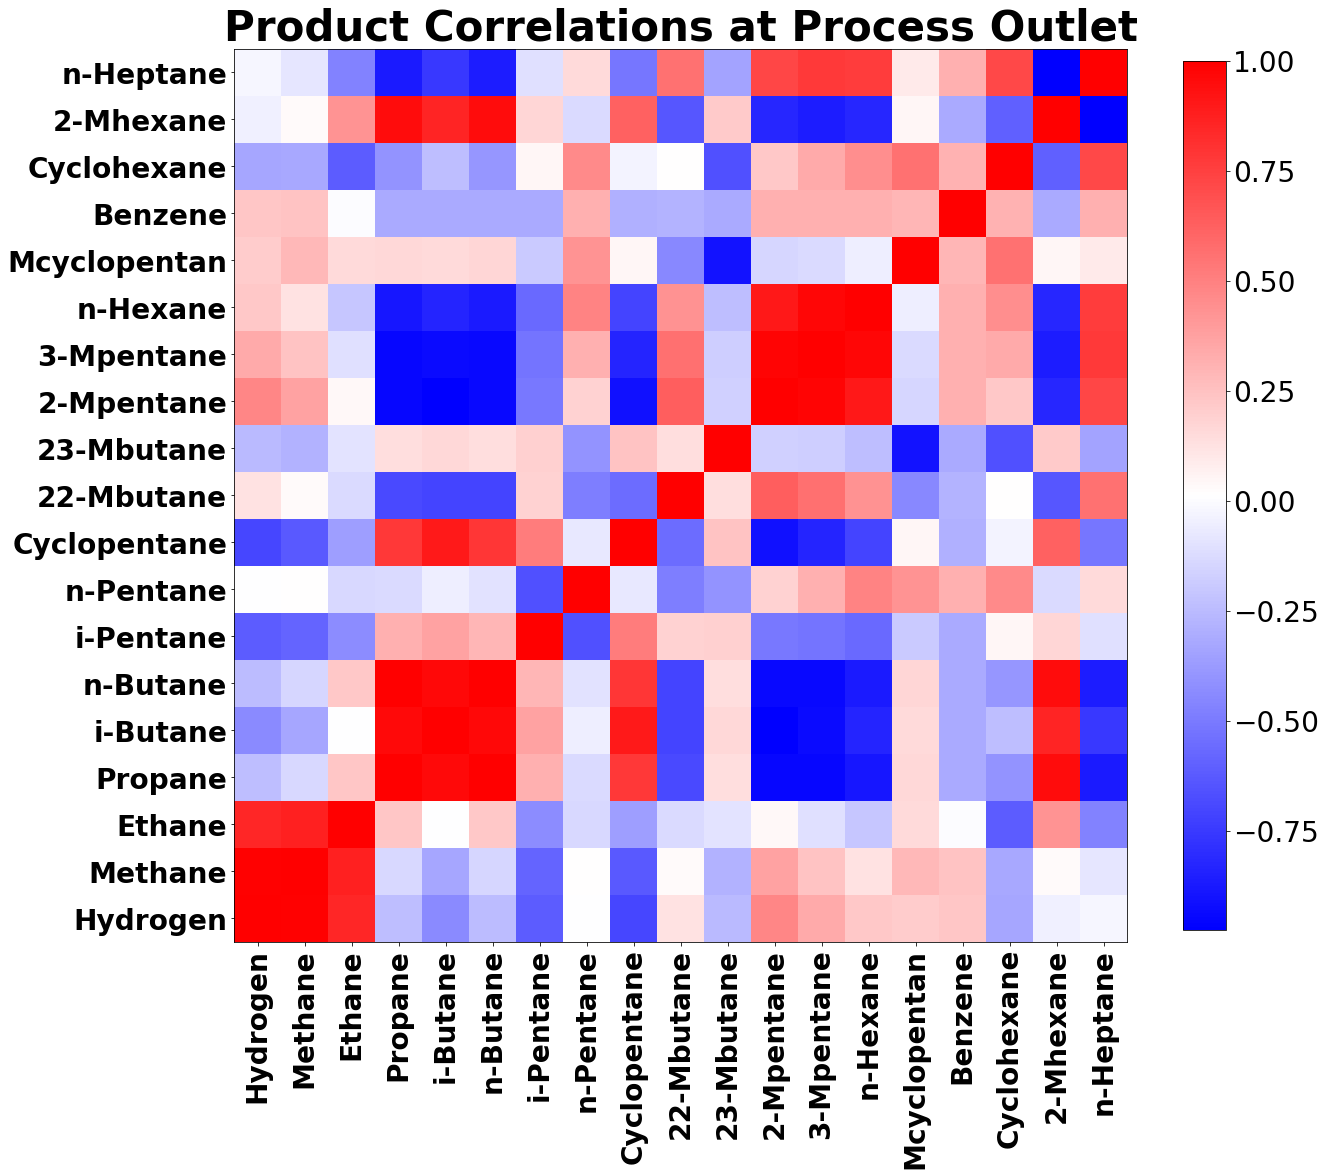

In [7]:
product_cols = [
"Hydrogen",
"Methane",
"Ethane",
"Propane",
"i-Butane",
"n-Butane",
"i-Pentane", 
"n-Pentane",
"Cyclopentane",
"22-Mbutane",
"23-Mbutane",
"2-Mpentane",
"3-Mpentane",
"n-Hexane",
"Mcyclopentan",
"Benzene",
"Cyclohexane",
"2-Mhexane",
"n-Heptane"]

for outlet in ['process']:
    actual_cols = ["%s_%s" % (outlet, c) for c in product_cols]
    
#     Z = rng.random((df.shape[0], len(product_cols)))
#     Z = np.exp(Z) / np.sum(np.exp(Z), axis=1, keepdims=True)
#     df[actual_cols] = Z
    corr_mat = dfe[actual_cols].corr('spearman')
    n = len(actual_cols)

    f, ax = plt.subplots(1, 1, figsize=(20, 20))
    im = ax.imshow(corr_mat, origin='lower', cmap='bwr')
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(product_cols, rotation=90, fontsize=28, fontweight='bold')
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(product_cols, fontsize=28, fontweight='bold')
    cbar = f.colorbar(im, ax=ax, shrink=0.8)
    cbar.ax.tick_params(labelsize=28) 
    ax.set_title("Product Correlations at Process Outlet", fontsize=42, fontweight='bold')
plt.savefig("tmp/fig5.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, pil_kwargs={"compression": "tiff_lzw"})

# Globally optimize targets

In [8]:
target_cols = ['process_ron', 'process_yield', 'r1_charge_heater']
target_modes = [np.argmax, np.argmax, np.argmin]

monitored_cols = target_cols + ['r1_temp', 'r1_pressure', 'r2_temp', 'r2_pressure']

ffdf = dfe[dfe['r1_charge_heater'] >= 0]

ixs = []
for target_col, target_mode in zip(target_cols, target_modes):
    ix_best = target_mode(ffdf[target_col])
    ixs.append(ix_best)

global_sol = ffdf.iloc[ixs][monitored_cols].copy()
global_sol.index = target_cols
global_sol.index.rename('optimization target', inplace=True)
global_sol['optimization mode'] = [tm.__name__.replace('arg','') for tm in target_modes]
global_sol = global_sol[['optimization mode'] + list(global_sol.columns)[:-1]]
global_sol['r1_charge_heater'] /= 1000000
global_sol

,optimization mode,process_ron,process_yield,r1_charge_heater,r1_temp,r1_pressure,r2_temp,r2_pressure
optimization target,,,,,,,,
process_ron,max,84.399594,95.958417,5.289324,166.0,50.0,152.0,90.0
process_yield,max,77.084749,100.294469,5.977331,128.0,90.0,128.0,90.0
r1_charge_heater,min,83.733951,96.816773,0.000697,162.0,90.0,134.0,90.0


In [9]:
global_sol.to_excel("tmp/global_optima.xlsx")

# Effect of R1 and R2 on Process RON

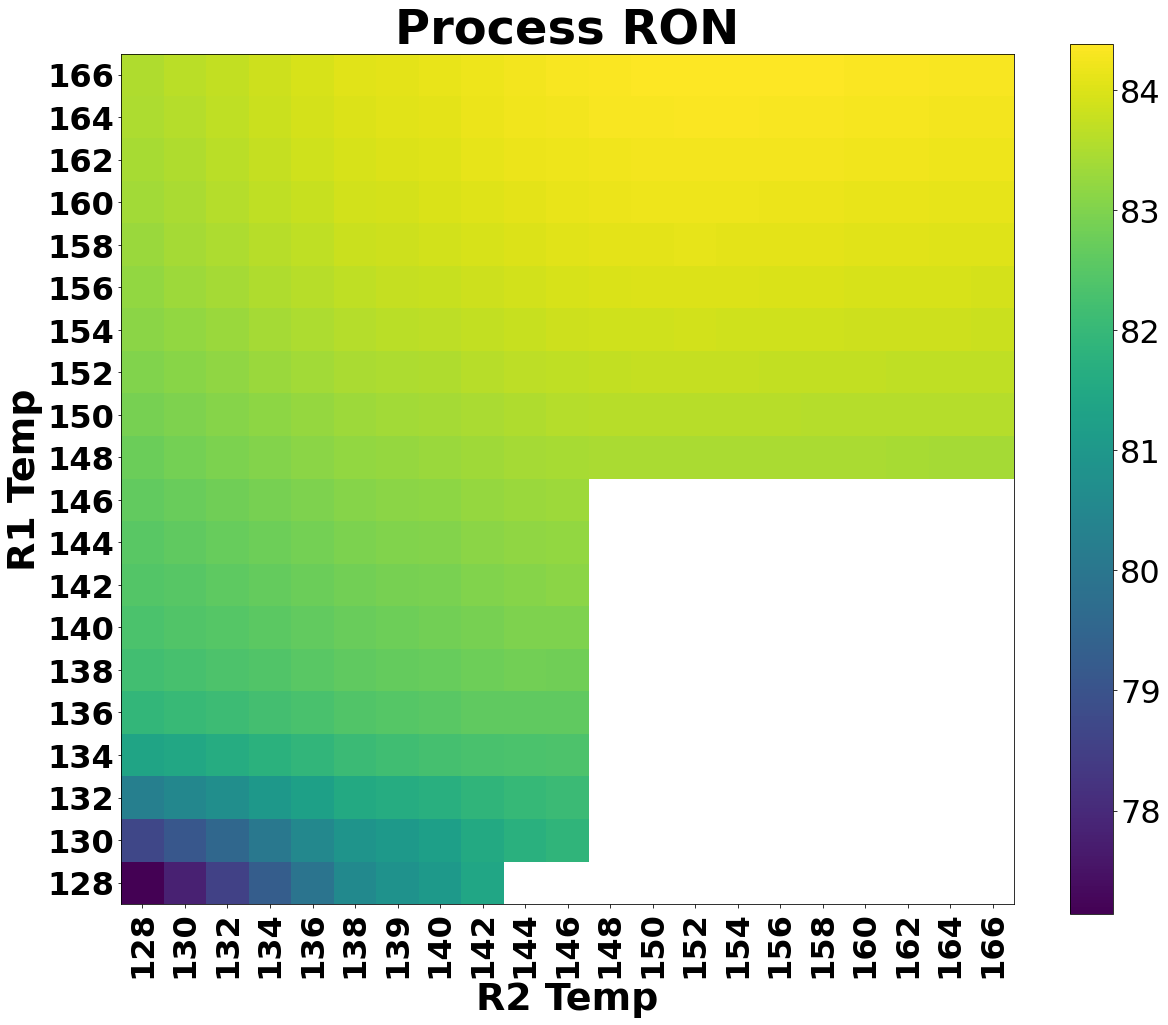

In [10]:
r1s = sorted(set(dfe['r1_temp']))
r2s = sorted(set(dfe['r2_temp']))
dependent_var = 'process_ron'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = dfe[(dfe['r1_temp'] == r1t) & (dfe['r2_temp'] == r2t)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

n,m = M.shape

f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower')
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=32, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=32, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=38, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=38, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=32) 
ax.set_title('Process RON', fontsize=48, fontweight='bold')
plt.savefig("tmp/fig7_ron.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, pil_kwargs={"compression": "tiff_lzw"})


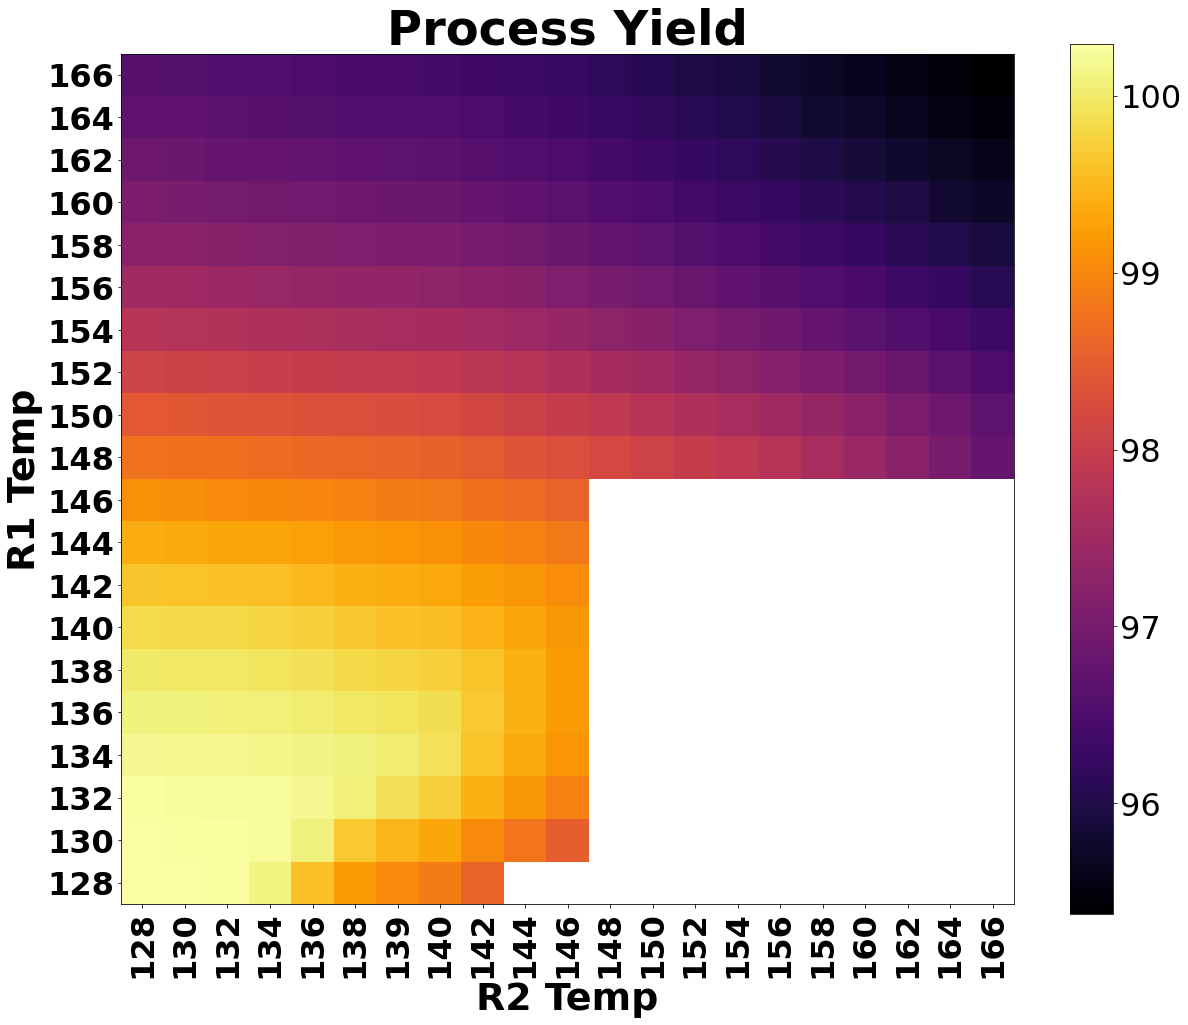

In [11]:
r1s = sorted(set(dfe['r1_temp']))
r2s = sorted(set(dfe['r2_temp']))
dependent_var = 'process_yield'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = dfe[(dfe['r1_temp'] == r1t) & (dfe['r2_temp'] == r2t)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

n,m = M.shape

f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower', cmap='inferno')
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=32, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=32, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=38, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=38, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=32) 
ax.set_title('Process Yield', fontsize=48, fontweight='bold')
plt.savefig("tmp/fig7_yield.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, 
            pil_kwargs={"compression": "tiff_lzw"})


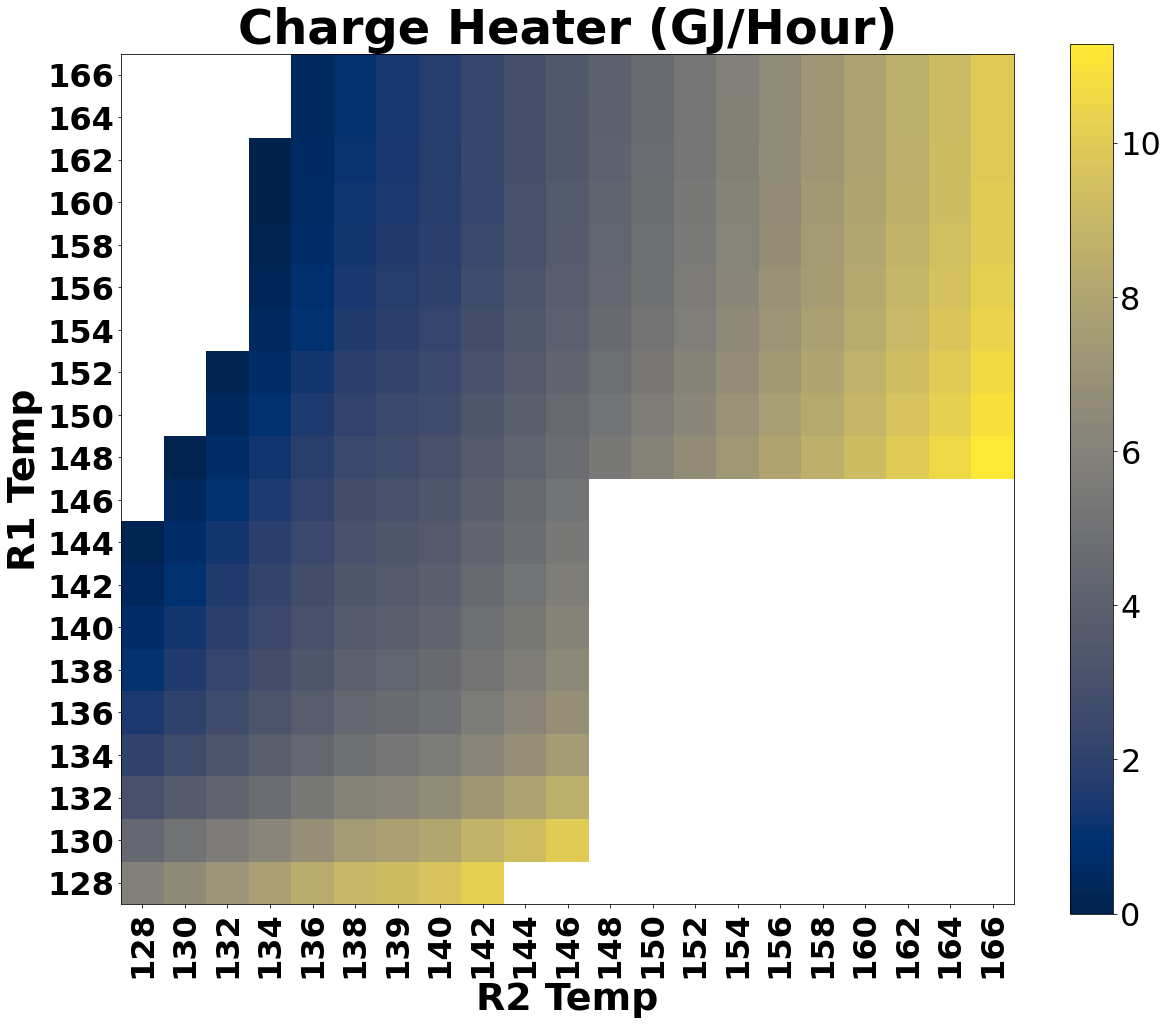

In [12]:
r1s = sorted(set(dfe['r1_temp']))
r2s = sorted(set(dfe['r2_temp']))
dependent_var = 'r1_charge_heater'

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = dfe[(dfe['r1_temp'] == r1t) & (dfe['r2_temp'] == r2t) & (dfe['r1_charge_heater'] >= 0)]
        mean_dep = np.mean(sdf[dependent_var])
        M[i, j] = mean_dep

n,m = M.shape

M = M / (1000*1000)
f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower', vmin=0, cmap='cividis')
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=32, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=32, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=38, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=38, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=32) 

ax.set_title('Charge Heater (GJ/Hour)', fontsize=48, fontweight='bold')
plt.savefig("tmp/fig7_charge_heater.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, pil_kwargs={"compression": "tiff_lzw"})


In [13]:
from PIL import Image

im1 = Image.open('tmp/fig7_ron.tiff')
im2 = Image.open('tmp/fig7_yield.tiff')
im3 = Image.open('tmp/fig7_charge_heater.tiff')

dst = Image.new('RGB', (im1.width + im2.width + im3.width, im1.height))
dst.paste(im1, (0, 0))
dst.paste(im2, (im1.width, 0))
dst.paste(im3, (im1.width + im2.width, 0))

dst.save('tmp/fig7.tiff', compression='tiff_lzw')

# Constrained Optimization of Charge Heater

In [14]:
min_ch = np.min(dfe[dfe['r1_charge_heater'] > 0]['r1_charge_heater'])
print("Min CH: %f" % min_ch)

thres_ron = [82, 82.5, 83.0, 83.5, 84.0]
thres_yield = [95, 96, 97, 98, 99]

results = []
matrix_format = []
for min_ron in thres_ron:
    
    row = np.zeros(len(thres_yield))
    matrix_format.append(row)
    
    for j, min_yield in enumerate(thres_yield):
        
        ix = (ffdf['process_ron'] >= min_ron) & (ffdf['process_yield'] >= min_yield)
        
        if np.sum(ix) > 0:
            sdf = ffdf[ix]
            
            best_ix = np.argmin(sdf['r1_charge_heater'])
            best_index = sdf.index[best_ix]
            
            results.append((min_ron, min_yield, best_index)) 
            
            fold_increase = ffdf.loc[best_index]['r1_charge_heater']
            
            row[j] = fold_increase
matrix_format = np.array(matrix_format)
results = np.array(results)
matrix_df = pd.DataFrame(data=matrix_format, columns=thres_yield, index=thres_ron)
matrix_df.to_csv("tmp/matrix_format.csv",index=True)

Min CH: 696.953257


In [15]:
constrained_sol = ffdf.loc[results[:,2]][monitored_cols].copy()
constrained_sol['min_ron'] = results[:,0]
constrained_sol['min_yield'] = results[:,1]
constrained_sol['increase_in_energy'] = (constrained_sol['r1_charge_heater'] - min_ch) / min_ch
constrained_sol.to_csv("tmp/constrained_sol.csv",index=True)

In [16]:
min_rons = np.linspace(82, 84, 20)
min_yields = np.linspace(95, 99, 20)
opt_ch = np.zeros((min_rons.shape[0], min_yields.shape[0]))
for i in range(min_rons.shape[0]):
    for j in range(min_yields.shape[0]):
        min_ron = min_rons[i]
        min_yield = min_yields[j]
        ix = (ffdf['process_ron'] >= min_ron) & (ffdf['process_yield'] >= min_yield)
        if np.sum(ix) > 0:
            sdf = ffdf[ix]
#             best_ix = np.argmin(sdf['r1_charge_heater'])
#             best_index = sdf.index[best_ix]
            opt_ch[i, j] = np.min(sdf['r1_charge_heater'])
        else:
            opt_ch[i,j] = np.nan

696.953257472589


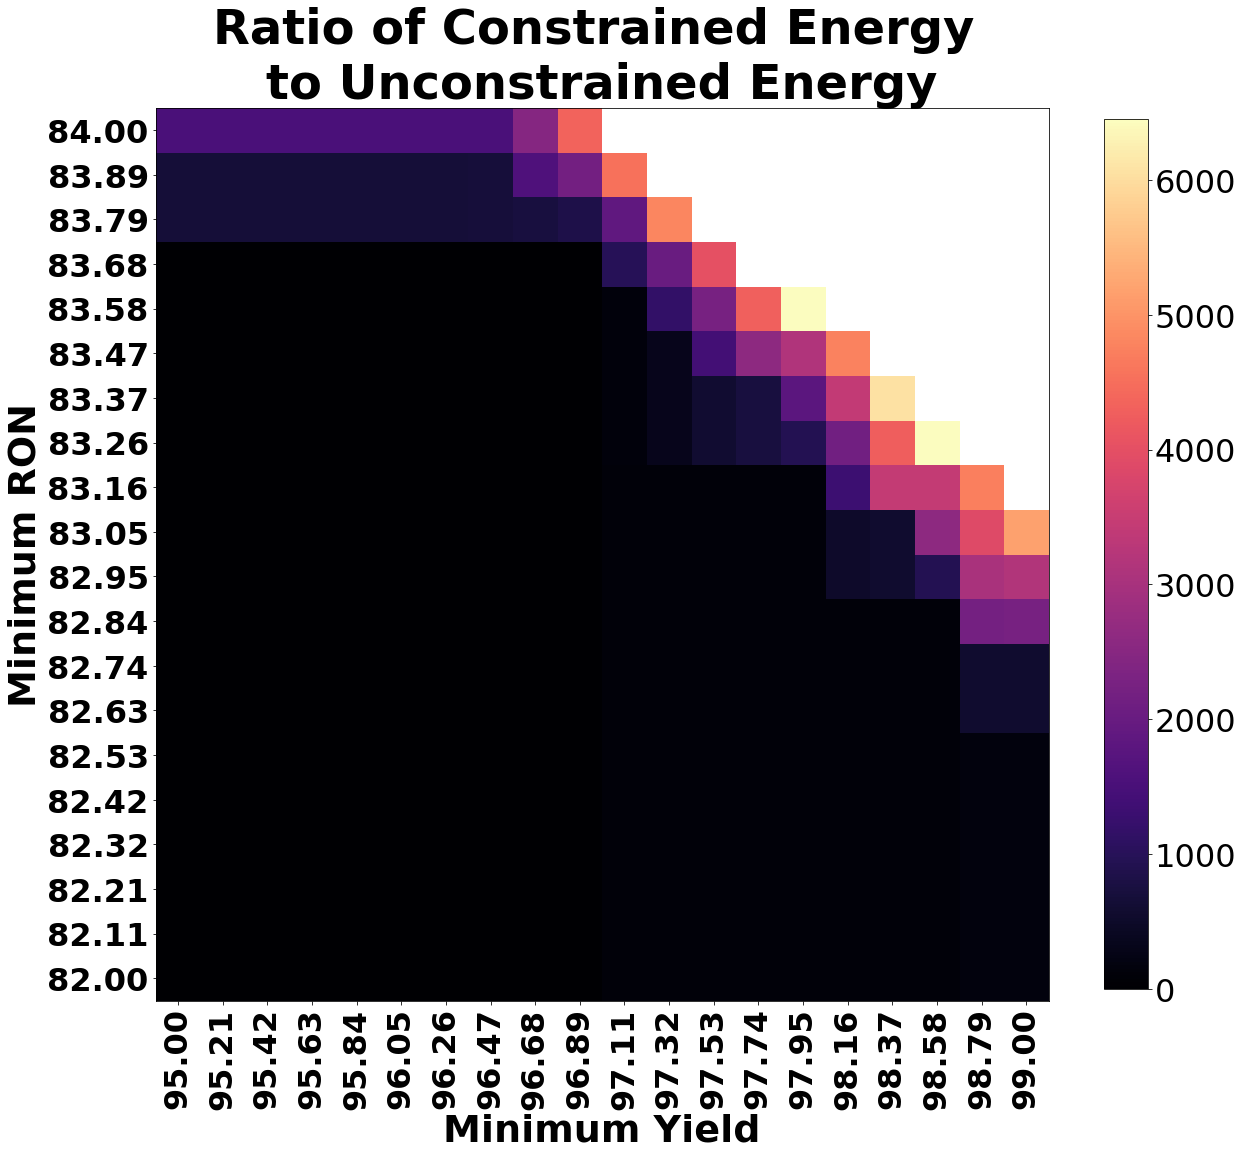

In [17]:
n,m = opt_ch.shape
print(min_ch)
M = opt_ch / min_ch
f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower', vmin=0, cmap='magma')
ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%4.2f' % d for d in min_yields], rotation=90, fontsize=32, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%4.2f' % d for d in min_rons], fontsize=32, fontweight='bold')
ax.set_xlabel('Minimum Yield', fontsize=38, fontweight='bold')
ax.set_ylabel('Minimum RON', fontsize=38, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=32) 

ax.set_title('Ratio of Constrained Energy \nto Unconstrained Energy', fontsize=48, fontweight='bold')
plt.savefig("tmp/fig8.tiff", bbox_inches='tight', transparent=True, pad_inches=0, dpi=300, pil_kwargs={"compression": "tiff_lzw"})


140.000000,146.000000
142.000000,142.000000
142.000000,144.000000
142.000000,146.000000
144.000000,139.000000
144.000000,140.000000
144.000000,142.000000
144.000000,144.000000
144.000000,146.000000
146.000000,136.000000
146.000000,138.000000
146.000000,139.000000
146.000000,140.000000
146.000000,142.000000
146.000000,144.000000
146.000000,146.000000
148.000000,134.000000
148.000000,136.000000
148.000000,138.000000
148.000000,139.000000
148.000000,140.000000
148.000000,142.000000
148.000000,144.000000
148.000000,146.000000
148.000000,148.000000
148.000000,150.000000
148.000000,152.000000
150.000000,132.000000
150.000000,134.000000
150.000000,136.000000
150.000000,138.000000
150.000000,139.000000
150.000000,140.000000
150.000000,142.000000
150.000000,144.000000
150.000000,146.000000
152.000000,132.000000
152.000000,134.000000
152.000000,136.000000


Text(0.5, 1.0, 'Effect of Reactor \n Temperatures on Charge Heater')

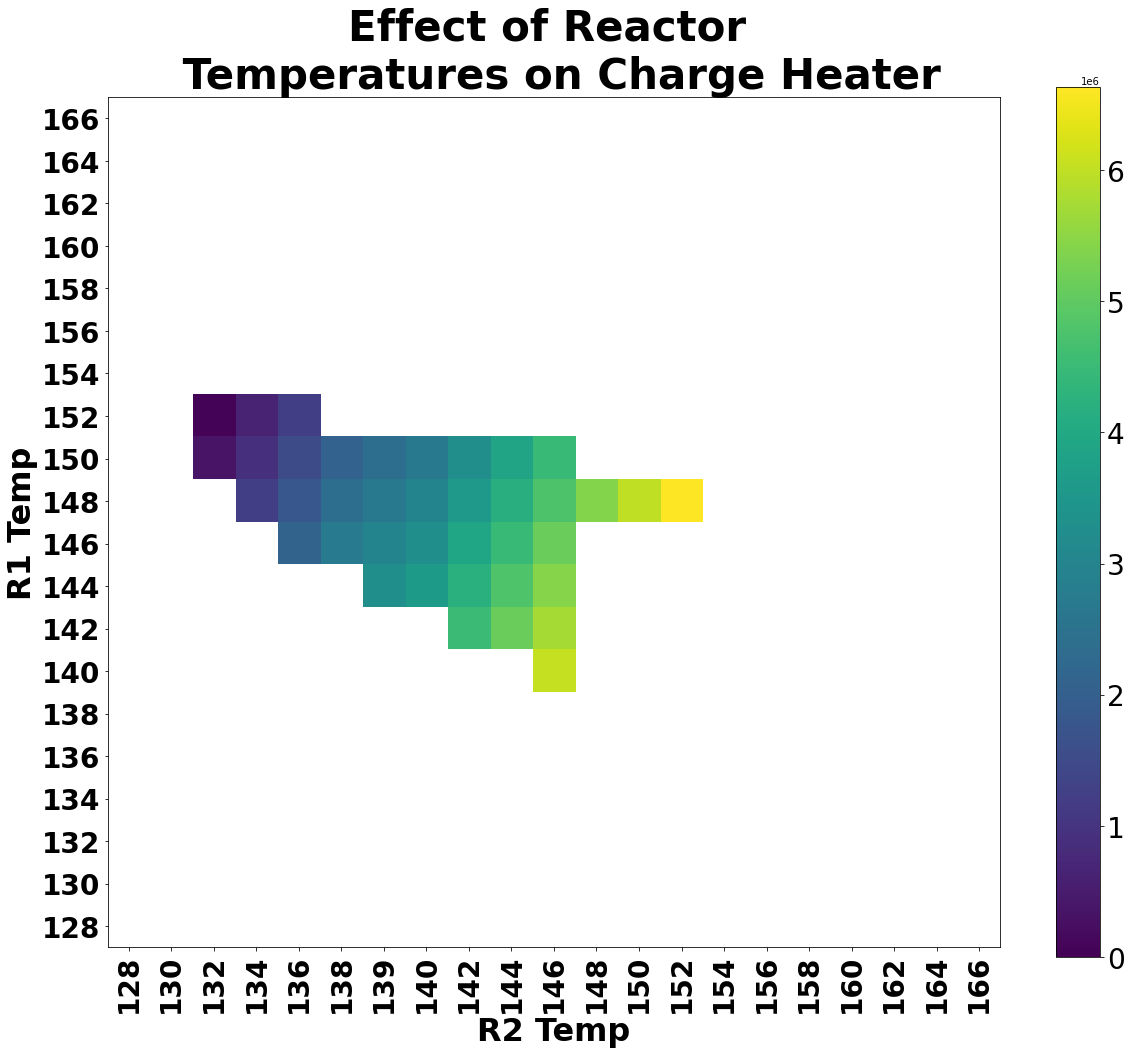

In [18]:
r1s = sorted(set(dfe['r1_temp']))
r1idxs = dict(zip(r1s, range(len(r1s))))
r2s = sorted(set(dfe['r2_temp']))
r2idxs = dict(zip(r2s, range(len(r2s))))
dependent_var = 'r1_charge_heater'

yield_var = 'process_yield'
ron_var = 'process_ron'
min_yield = 98
min_ron = 83

M = np.zeros((len(r1s), len(r2s)))
for i, r1t in enumerate(r1s):
    for j, r2t in enumerate(r2s):
        sdf = dfe[(dfe['r1_temp'] == r1t) & (dfe['r2_temp'] == r2t) & (dfe['r1_charge_heater'] >= 0)]
        mean_dep = np.min(sdf[dependent_var])
        yields = sdf[yield_var]
        rons = sdf[ron_var]
        
        if np.any((yields >= min_yield) & (rons >= min_ron)):
            print("%f,%f" % (r1t,r2t))
            M[i, j] = mean_dep
        else:
            M[i, j] = np.nan

n,m = M.shape
f, ax = plt.subplots(1, 1, figsize=(20, 20))
im = ax.imshow(M, origin='lower', vmin=0)

ax.set_xticks(np.arange(m))
ax.set_xticklabels(['%d' % d for d in r2s], rotation=90, fontsize=28, fontweight='bold')
ax.set_yticks(np.arange(n))
ax.set_yticklabels(['%d' % d for d in r1s], fontsize=28, fontweight='bold')
ax.set_xlabel('R2 Temp', fontsize=32, fontweight='bold')
ax.set_ylabel('R1 Temp', fontsize=32, fontweight='bold')
cbar = f.colorbar(im, ax=ax, shrink=0.8)
cbar.ax.tick_params(labelsize=28) 
ax.set_title('Effect of Reactor \n Temperatures on Charge Heater', fontsize=42, fontweight='bold')

In [32]:
ix = (dfe['process_ron'] >= 83) & (dfe['process_yield'] >= 99) & (dfe['r1_charge_heater'] > 0)
np.sum(ix)


135